### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [5]:
unique_metrics = ['euclidean',
 'braycurtis',
 'canberra',
 'cityblock',
 'chebyshev',
 'clark',
 'correlation',
 'cosine',
 'hellinger',
 'jaccard',
 'lorentzian',
 'marylandbridge',
 'meehl',
 'soergel',
 'wave_hedges',
 'kulczynski',
 'add_chisq',
 'acc',
 'chebyshev_min',
 'dice',
 'divergence',
 'google',
 'jeffreys',
 'kumarjohnson',
 'penroseshape',
 'squared_chisq',
 'squaredchord',
 'squared_euclidean',
 'taneja',
 'topsoe',
 'vicis_symmetric_chisq',
 'vicis_wave_hedges']

final_features = ['SPM_A_Y',
 'Multiband_period',
 'r-i',
 'Harmonics_phase_4_i',
 'Harmonics_phase_2_r',
 'Power_rate_4']

In [6]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [7]:
features = features.sample(frac=1)

In [8]:
y_df = features["class"]
# X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)
X_df = features.loc[:,final_features]

In [9]:
y = y_df.to_numpy()
X = X_df.to_numpy()

### 1. Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [11]:
def runif(random_state):
  clf = IsolationForest(max_samples=10, contamination='auto', random_state=random_state)
  clf.fit(X) #, sample_weight=1.0/(Xfixed[:,2,:])**2)
  scores_pred_Norm = clf.decision_function(X)
  #scores_pred_Norm = clf.score_samples(X)
  #.sample_score(X)

  threshold_Norm  = stats.scoreatpercentile(scores_pred_Norm ,100 * 0.1)
  y_predNorm = clf.predict(X)
  abornmality = -scores_pred_Norm
  iforest_df = pd.DataFrame(abornmality, columns=["abnormality"]) # higher is more abnormal
  iforest_df.index.name = "sample_num"
  iforest_df=iforest_df.sort_values(by="abnormality", ascending=False)
  return iforest_df.index, iforest_df


In [12]:
ranksIF = []
ranksIDdfs = []
ifseeds = np.random.randint(100,1000, 3)
for i in ifseeds:
  _ = runif(i)
  ranksIF.append(_[0])
  ranksIDdfs.append(_[1])
ranksIF

[Index([2007,  548, 2092,  966, 1747,  151, 2153,  744, 2723,  933,
        ...
        1472, 1843, 1411, 1222,  364, 2085, 2427, 1487, 1388,  616],
       dtype='int64', name='sample_num', length=2732),
 Index([2007,  151,  548,  966, 2092,  933, 2301,  131,  773, 2723,
        ...
        1353, 1113, 2368,  918, 1029, 1411, 2311,  785, 1540, 1567],
       dtype='int64', name='sample_num', length=2732),
 Index([2007,  548,  151,  773,  966,  744, 1055, 1747,  131,  296,
        ...
        1045, 2299, 1806, 1411, 2322, 2643, 2158, 2427, 1437, 1353],
       dtype='int64', name='sample_num', length=2732)]

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/3690008507.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(np.full(n_items, i+1), np.arange(1, n_items + 1), 'ro', markersize=6, color='black')


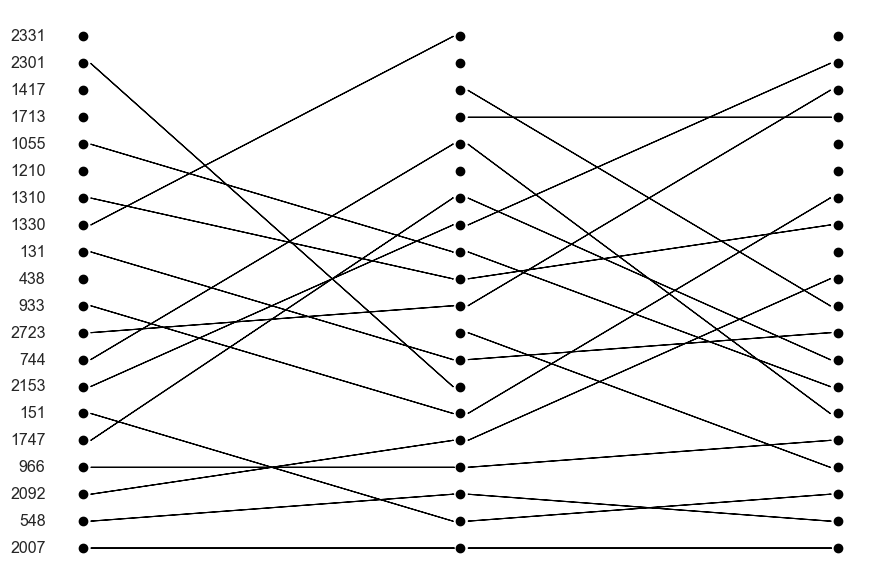

In [13]:
import matplotlib.pyplot as plt
import numpy as np
def plotstuff(list_a, list_b, i, ax, arrow_len=0.1):
# Plot the two columns of equidistant points
      a = list(list_a)
      b = list(list_b)
      a_to_b_indices = [b.index(x) + 1 if x in b else None for x in a]
      for j, target_index in enumerate(a_to_b_indices):
        if target_index is not None:
            ax.arrow(0.02 + i, j + 1, 0.96, target_index - (j + 1),
                     #head_width=0.05 * arrow_len * 10, head_length=0.1 * arrow_len * 10,
                     fc='black', ec='black', length_includes_head=False)




def plot_ranks(rankslists, nsamples=10, labels_offset=0.1):
    """
    Plots two columns of points representing two lists (a and b)
    and draws arrows connecting the rank of elements in 'a' to
    their corresponding position in 'b'.

    Args:
        a (list): The first list of elements.
        b (list): The second list of elements.
        labels_offset (float, optional): Offset for the text labels. Defaults to 0.1.
        arrow_len (float, optional): Length of the arrows. Defaults to 0.1.
    """
    n_items = nsamples
    fig, ax = plt.subplots(figsize=(3 * len(rankslists), n_items * 0.3)) # Adjust figure size

    for i in range(len(rankslists)):
      if i == 0:
        a = rankslists[i][:nsamples]
        ax.plot(np.ones(n_items), np.arange(1, n_items + 1), 'o', markersize=6, color='black')
        for j, val in enumerate(a):
            ax.text(1 - labels_offset, j + 1, str(val), ha='right', va='center')
      else:
        b = rankslists[i][:nsamples]
        a = rankslists[i-1][:nsamples]
        ax.plot(np.full(n_items, i+1), np.arange(1, n_items + 1), 'ro', markersize=6, color='black')
        for j, val in enumerate(b):
            if not val in b:
              ax.text(1 - labels_offset + i, j + 1, str(val), ha='right', va='center')
        plotstuff(a, b, i, ax)


      # Remove axes and labels
      #ax.set_xlim(0, 3)
    ax.set_ylim(0, n_items + 1)
    ax.axis('off')
    plt.tight_layout()

    plt.show()

plot_ranks(ranksIF, nsamples=20);

In [14]:
ranksIDdfs[0]

,abnormality
sample_num,
2007,0.153602
548,0.151189
2092,0.144949
966,0.142569
1747,0.140443
...,...
2085,-0.082787
2427,-0.083877
1487,-0.084936


In [15]:
# prompt: make a dataframe column that shows in which quantile a value in ranksIF[0] is


# Assuming ranksIF is already defined as in your provided code
df = ranksIDdfs[0]
# Create a DataFrame from the first list in ranksIF
for rdf in ranksIDdfs[1:]:
  df = df.merge(rdf, left_index=True, right_index=True)
df.columns = ["if1", "if2", "if3"]

# Calculate quantiles

for c in df.columns:

  df['quartile_'+c] = pd.qcut(df[c], q=4, labels=False)  # Divides into 4 quantiles
#for c in df.columns:

#  df['quantile_'+c] = pd.qcut(df[c], q=[0.99, 0.95, 0.9, 0.1, 0.05, 0.01], labels=False)  # Divides into 4 quantiles

# Print the DataFrame
df


,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3
sample_num,,,,,,
2007,0.153602,0.155124,0.154811,3,3,3
548,0.151189,0.152706,0.151189,3,3,3
2092,0.144949,0.147896,0.131143,3,3,3
966,0.142569,0.149095,0.140373,3,3,3
1747,0.140443,0.133194,0.139015,3,3,3
...,...,...,...,...,...,...
2085,-0.082787,-0.057494,-0.072321,0,0,0
2427,-0.083877,-0.071587,-0.087401,0,0,0
1487,-0.084936,-0.063280,-0.073858,0,0,0


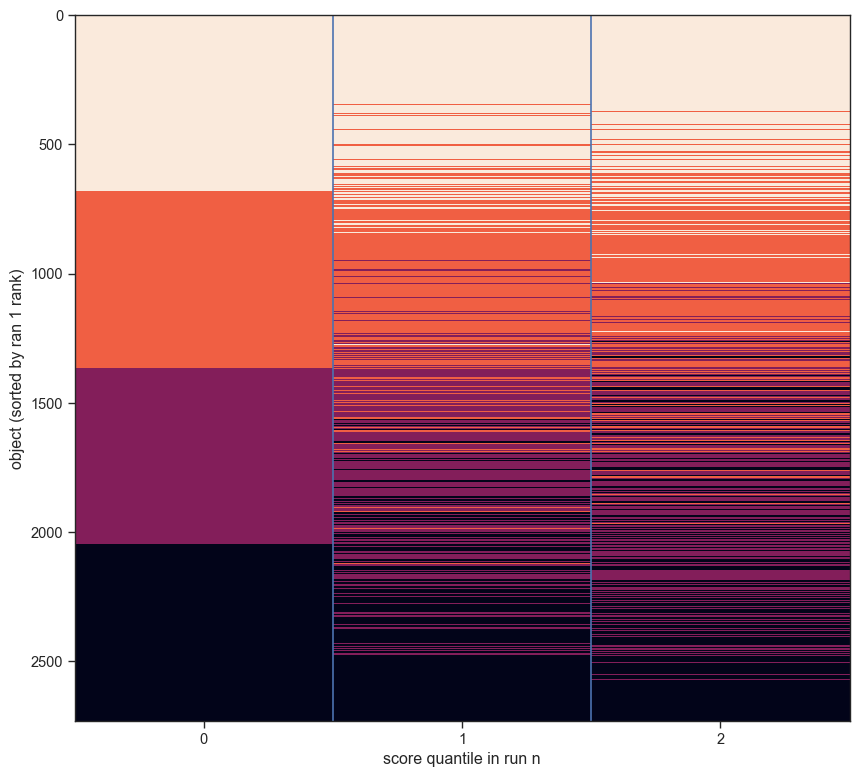

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(df.iloc[:,3:], interpolation='none')
ax.set_aspect(0.001)
ax.set_xlabel("score quantile in run n")
ax.set_xticks(range(len(df.columns)-3))
ax.set_ylabel("object (sorted by ran 1 rank)")
plt.grid(None)
ax.axvline(0.5)
ax.axvline(1.5)


In [17]:
top_quantile = df[df["quartile_if1"]==df["quartile_if1"].max()].iloc[:,3:]
print(f'fraction of run2 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if2"]).sum() / top_quantile.shape[0]}')
print(f'fraction of run3 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if3"]).sum() / top_quantile.shape[0]}')


fraction of run2 top quantile in run 1 0.8814055636896047
fraction of run3 top quantile in run 1 0.87701317715959


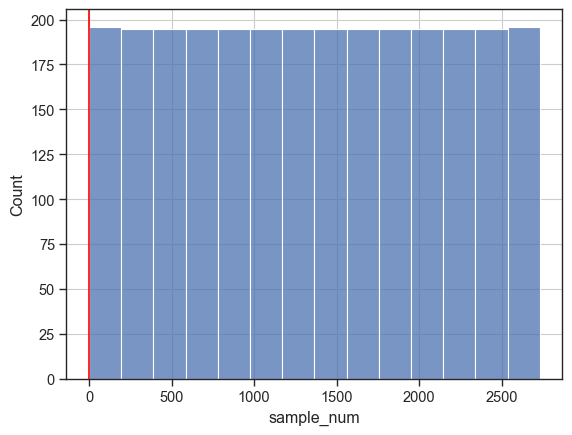

In [18]:
iforest_df = ranksIF[0]
sns.histplot(iforest_df)
plt.axvline(x=0, color="red",label="outlier boundary")
plt.show()

### 2. EDA Distance Distributions across:
- n objects
- m metrics
- k clusters

![https://i.imgur.com/pmOqUZM.png](https://i.imgur.com/pmOqUZM.png)

In [19]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X,y)

DistanceMetricClassifier()

In [20]:
dist_df_dict = {}
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df['minimum_distance'] = dist_df.min(axis=1)
    dist_df['median_distance'] = dist_df.median(axis=1)

    dist_df.index.name = "sample_num"
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
n_metrics = len(unique_metrics)
clusters = np.unique(y)
n_clusters =len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=2732
m: n_metrics=32
k: n_clusters=4


In [22]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i,f"{cluster}_dist"]

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/2410698257.py:8: RuntimeWarning: invalid value encountered in log10
  axs[j].hist(np.log10(dist_df_arr[objnum,j,:]), label=cluster)


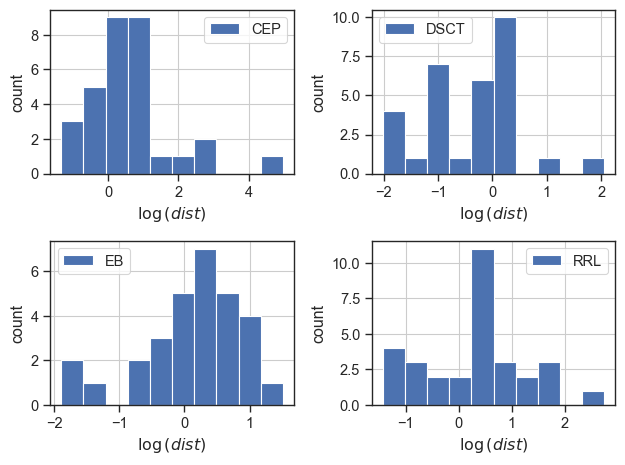

In [23]:
objnum = np.random.randint(1000)
# one cluster each plot
# all distance metrics in each plot

fig, ax = plt.subplots(2,2)
axs = ax.ravel()
for j, cluster in enumerate(clusters):
    axs[j].hist(np.log10(dist_df_arr[objnum,j,:]), label=cluster)
    # axs[j].set_xscale("log")
    axs[j].legend()
    axs[j].set_xlabel(r"$\log{(dist)}$")
    axs[j].set_ylabel("count")
plt.tight_layout()
plt.show()

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/1282755283.py:4: RuntimeWarning: invalid value encountered in log10
  sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/1282755283.py:4: RuntimeWarning: invalid value encountered in log10
  sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/1282755283.py:4: RuntimeWarning: divide by zero encountered in log10
  sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/1282755283.py:4: RuntimeWarning: invalid value encountered in log10
  sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/1282755283.py:

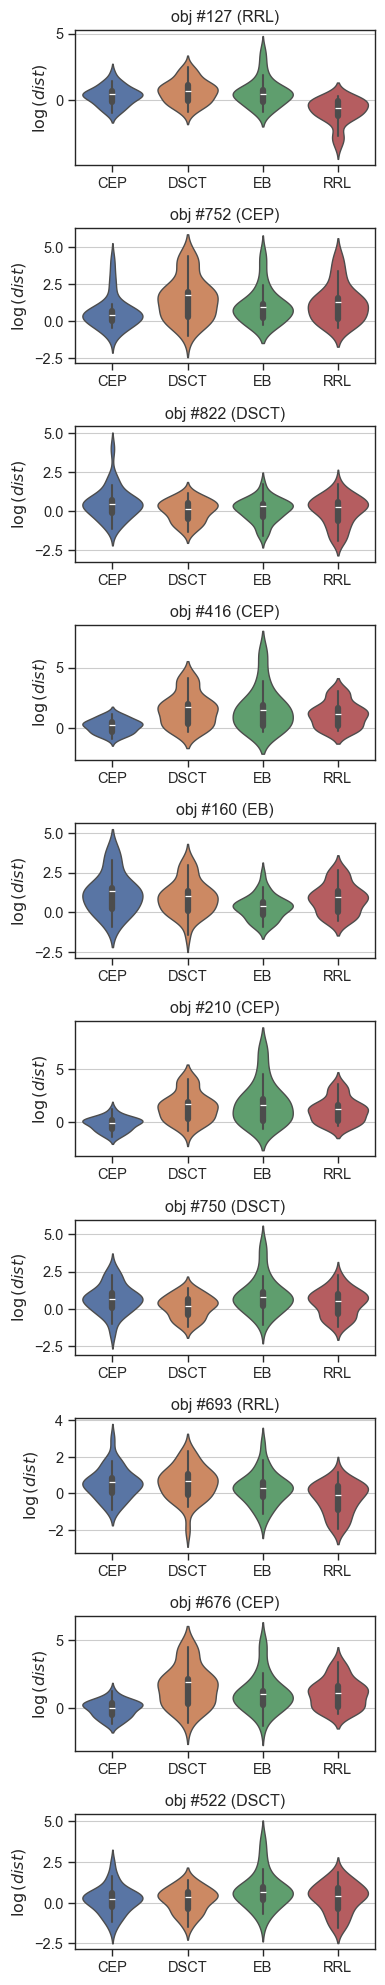

In [24]:
fig, axs = plt.subplots(10, 1, figsize=(4, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.violinplot(data=pd.DataFrame(np.log10(dist_df_arr[objnum]).T, columns=clusters),ax=axs[i])
    plt.title(f'Distribution of log10 distances for object {objnum}')
    axs[i].set_ylabel(r"$\log{(dist)}$")
    axs[i].set_title(f"obj #{objnum} ({y[objnum]})")
plt.tight_layout()
plt.show()

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/3907077689.py:4: RuntimeWarning: invalid value encountered in log10
  sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum]), index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/3907077689.py:4: RuntimeWarning: invalid value encountered in log10
  sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum]), index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/3907077689.py:4: RuntimeWarning: invalid value encountered in log10
  sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum]), index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_60623/3907077689.py:4: RuntimeWarning: invalid value encountered in log10
  sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum]), index=clusters, columns=unique_metrics),cmap="R

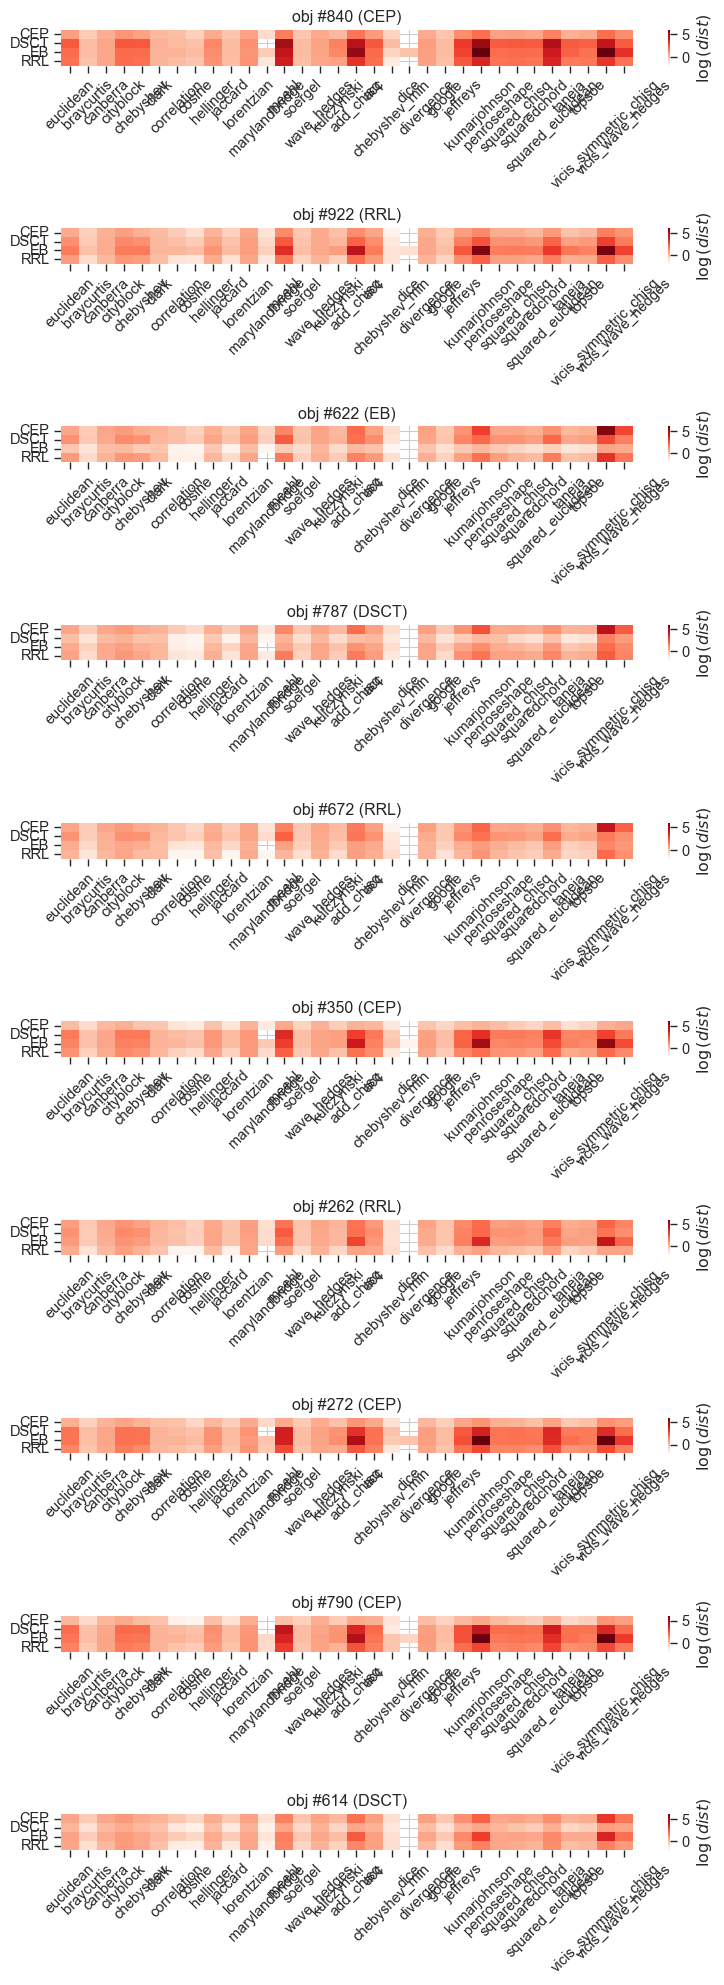

In [25]:
fig, axs = plt.subplots(10, 1, figsize=(8, 20))
axs = axs.ravel()
for i, objnum in enumerate(np.random.randint(1000,size=10)):
    sns.heatmap(pd.DataFrame(np.log10(dist_df_arr[objnum]), index=clusters, columns=unique_metrics),cmap="Reds",ax=axs[i],
                vmin=-2, vmax=6, cbar_kws={'label': r"$\log{(dist)}$"})
    axs[i].set_title(f"obj #{objnum} ({y[objnum]})")
    axs[i].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

## 3. DCPY

In [26]:
cluster_aggregates = ["min", "median"]
metric_aggregates = ["min", "p25", "median"]

In [27]:
dist_df_dict["Euclidean"]

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,minimum_distance,median_distance
sample_num,,,,,,
0,2.209896,25.592811,1.104496,5.959847,1.104496,2.209896
1,1.946372,1.139751,2.300466,3.877626,1.139751,1.946372
2,2.342092,0.979555,2.997537,4.538072,0.979555,2.342092
3,3.689259,3.160871,3.851688,3.880139,3.160871,3.689259
4,1.901970,3.797602,0.889963,7.314538,0.889963,1.901970
...,...,...,...,...,...,...
2727,1.755366,65.389556,38.496997,18.386016,1.755366,18.386016
2728,4.089808,10.095470,8.181492,2.570897,2.570897,4.089808
2729,1.568315,81.382515,37.566716,22.049838,1.568315,22.049838


In [28]:
dist_aggregates = np.zeros(( len(dist_df_dict["Euclidean"]), 3, 2))
dist_aggregates.shape

(2732, 3, 2)

In [29]:
dist_df_dict[utils.get_metric_name(metric)]

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,minimum_distance,median_distance
sample_num,,,,,,
0,196.145401,21.275020,22.879637,19.750936,19.750936,21.275020
1,249.154153,8.402903,12.086625,23.182878,8.402903,12.086625
2,91.402863,2.444103,28.202184,12.564333,2.444103,12.564333
3,194.311222,195.537040,191.110240,105.719766,105.719766,191.110240
4,471.031777,20.128267,6.731718,38.858505,6.731718,20.128267
...,...,...,...,...,...,...
2727,10.662221,82.718217,859.733619,36.973071,10.662221,36.973071
2728,15.352215,13.151550,170.917164,2.880204,2.880204,13.151550
2729,2.145053,71.867351,804.156626,23.444675,2.145053,23.444675


In [30]:
dist_minK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
                           for i,metric in enumerate(unique_metrics)])
dist_medK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
                           for i,metric in enumerate(unique_metrics)])

In [31]:
dist_aggregates = pd.DataFrame(np.concatenate([np.percentile(dist_minK_by_M, [0,0.25,0.5], axis=0),
                          np.percentile(dist_medK_by_M, [0,0.25,0.5], axis=0)]).T,
                          columns=[k+m for k in ["min", "med"] for m in ["min", "25th", "med"]])

dist_aggregates = dist_aggregates.merge(df.iloc[:,:3], left_index=True, right_index=True)
dist_aggregates

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
0,-7.604772,-7.015187,-6.425602,-2.627908,-2.419245,-2.210582,-0.068849,-0.071211,-0.046096
1,-9.787390,-9.028336,-8.269282,-2.746851,-2.533082,-2.319314,-0.055542,-0.054078,-0.056086
2,-9.346512,-8.628305,-7.910099,-2.892020,-2.667195,-2.442370,-0.029540,-0.041390,-0.058449
3,-9.643348,-8.894039,-8.144731,-2.384349,-2.195660,-2.006971,-0.024997,-0.017251,-0.030555
4,-6.325164,-5.845523,-5.365883,-1.880464,-1.733591,-1.586718,-0.031106,-0.036637,-0.025699
...,...,...,...,...,...,...,...,...,...
2727,-6.362009,-5.910474,-5.458938,-2.563427,-2.361948,-2.160468,0.047580,0.067950,0.086375
2728,-8.374162,-7.724447,-7.074733,-2.465196,-2.267708,-2.070220,-0.025326,-0.015337,-0.030888
2729,-7.201630,-6.723190,-6.244750,-2.789805,-2.573967,-2.358129,0.020288,0.024978,0.012036
2730,-9.651692,-8.909882,-8.168073,-2.890658,-2.666475,-2.442293,-0.051424,-0.054711,-0.072531


In [32]:
dist_aggregates_ranks = dist_aggregates.iloc[:, :].rank(axis=0, ascending=False).astype(int)
dist_aggregates_ranks

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
0,1166,1153,1124,1459,1451,1452,2616,2693,1999
1,2581,2579,2571,2010,2021,2032,2376,2470,2287
2,2105,2110,2125,2535,2535,2531,1615,2128,2337
3,2447,2432,2422,753,755,755,1520,1415,1551
4,733,711,696,386,384,383,1667,1962,1450
...,...,...,...,...,...,...,...,...,...
2727,745,750,768,1215,1223,1229,451,224,141
2728,1323,1318,1308,887,886,880,1522,1375,1560
2729,1063,1062,1065,2189,2200,2212,786,746,926
2730,2454,2458,2460,2529,2528,2530,2294,2485,2624


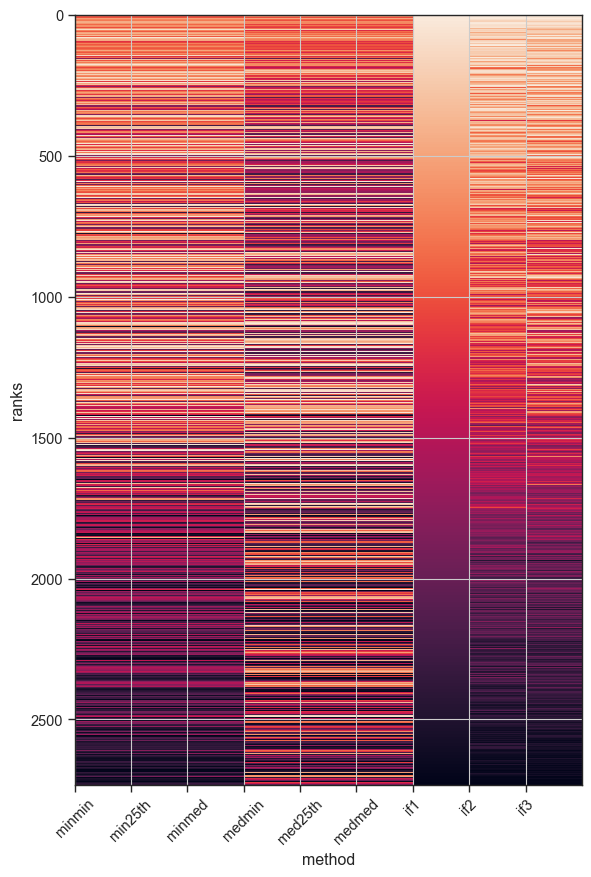

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(dist_aggregates_ranks.sort_values(by="if1", ascending=False), interpolation='none')
ax.set_aspect(0.005)
ax.set_xticks(np.arange(-0.5, 8.5), labels=dist_aggregates_ranks.columns, rotation=45)
ax.set_ylabel("ranks")
ax.set_xlabel("method")
ax.grid('off')

/Users/sidchaini/miniconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


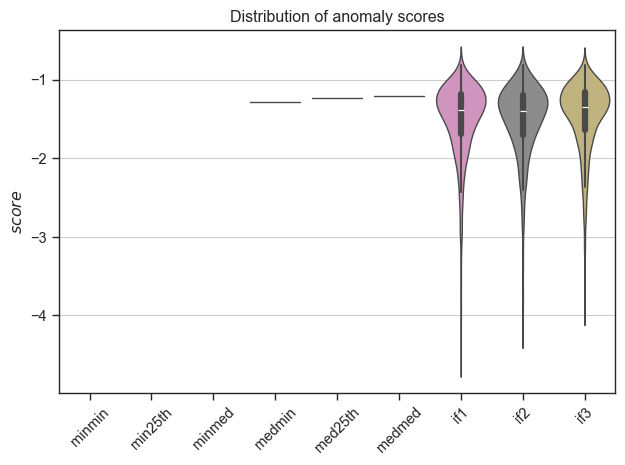

In [34]:
sns.violinplot(data=pd.DataFrame(np.log10(dist_aggregates), columns=dist_aggregates.columns))
plt.title(f'Distribution of anomaly scores')
plt.ylabel(r"$score$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
min_dists_across_clusters = []
median_dists_across_clusters = []

for metric in unique_metrics:
    metric_str = utils.get_metric_name(metric)
    dist_df = dist_df_dict[metric_str]
    min_dists_across_clusters.append(dist_df["minimum_distance"].to_numpy())
    median_dists_across_clusters.append(dist_df["median_distance"].to_numpy())


min_dists_across_clusters = np.array(min_dists_across_clusters)
median_dists_across_clusters = np.array(median_dists_across_clusters)

In [36]:
min_dists_across_clusters = []
median_dists_across_clusters = []

for metric in unique_metrics:
    metric_str = utils.get_metric_name(metric)
    dist_df = dist_df_dict[metric_str]
    min_dists_across_clusters.append(dist_df["minimum_distance"].to_numpy())
    median_dists_across_clusters.append(dist_df["median_distance"].to_numpy())

min_dists_across_clusters = np.array(min_dists_across_clusters)
median_dists_across_clusters = np.array(median_dists_across_clusters)

In [37]:
minK_pcM10_25_50 = np.percentile(min_dists_across_clusters, [0, 0.1, 0.25, 0.5], axis=0)
medianK_pcM10_25_50 = np.percentile(median_dists_across_clusters, [0, 0.1, 0.25, 0.5], axis=0)

In [38]:
min_dists_across_clusters.shape

(32, 2732)

In [39]:
df_all = pd.DataFrame(minK_pcM10_25_50.T, columns=["min_min", "min_pc10", "min_pc25", "min_pc50"])
df_all = df_all.merge(pd.DataFrame(medianK_pcM10_25_50.T,
                                   columns=["min_min", "median_pc10", "median_pc25", "median_pc50"]))
df_all

,min_min,min_pc10,min_pc25,min_pc50,median_pc10,median_pc25,median_pc50


### 4. Implanted Anomalies
Load features from other known classes from ELAsTiCC,and see if anomaly detectors can find them.

In [40]:
X_normal_df = X_df.copy() # "Normal" objects from the 4 classes from earlier
y_normal_df = y_df.copy() # "Normal" objects from the 4 classes from earlier

In [41]:
other_features_df = pd.read_parquet("data/otherclassobjs_features.parquet")
other_lc_df = pd.read_parquet("data/otherclassobjs.parquet")
assert (other_lc_df.index == other_features_df.index).all()

In [42]:
other_lc_df["class"].value_counts()

class
PISN-STELLA_HYDROGENIC    100
SNIax                     100
SNIb+HostXT_V19           100
SNII-NMF                  100
SNIIn+HostXT_V19          100
SNII-Templates            100
SNIc+HostXT_V19           100
Cepheid                   100
EB                        100
PISN-MOSFIT               100
SNIIn-MOSFIT              100
uLens-Single-GenLens      100
PISN-STELLA_HECORE        100
AGN                       100
RRL                       100
SLSN-I_no_host            100
SNIIb+HostXT_V19          100
CART                      100
SLSN-I+host               100
SNIa-SALT3                100
uLens-Single_PyLIMA       100
TDE                       100
SNIcBL+HostXT_V19         100
uLens-Binary              100
SNIc-Templates            100
ILOT                      100
dwarf-nova                100
d-Sct                     100
SNIb-Templates            100
SNII+HostXT_V19           100
SNIa-91bg                 100
Mdwarf-flare              100
SL-SN1a                    57
SL-S

In [43]:
# other_lc_df

In [44]:
# other_features_df

In [103]:
X_anom_df = other_features_df.loc[:,X_normal_df.columns].dropna()
y_anom_df = other_lc_df.loc[X_anom_df.index]["class"].to_numpy()

In [104]:
def runifalt(random_state, X_normal_df, X_anom_df):
    clf = IsolationForest(max_samples=10, contamination='auto', random_state=random_state)
    clf.fit(X_normal_df)
    scores_pred_Norm = clf.decision_function(X_anom_df)

    threshold_Norm  = stats.scoreatpercentile(scores_pred_Norm ,100 * 0.1)
    y_predNorm = clf.predict(X_anom_df)
    abornmality = -scores_pred_Norm
    iforest_df = pd.DataFrame(abornmality, columns=["abnormality"]) # higher is more abnormal
    iforest_df.index = X_anom_df.index
    iforest_df=iforest_df.sort_values(by="abnormality", ascending=False)
    return iforest_df.index, iforest_df

In [105]:
ranksIF = []
ranksIDdfs = []
for i in ifseeds:
  _ = runifalt(i,X_normal_df, X_anom_df)
  ranksIF.append(_[0])
  ranksIDdfs.append(_[1])
ranksIF

[Index([ 88253880,  37691298,  37734415,  75421831,  10208601,  46466259,
        118315745, 114522598,  50624238, 132288802,
        ...
         51160111,  80507288, 156440102,  72631153,  73575106,  40375263,
         31665678,  84882126,  59318074, 122726080],
       dtype='int64', length=1924),
 Index([ 91170406,  88253880,  75421831,  79249840, 114522598, 118315745,
         25891047,  37734415,  46466259,  10208601,
        ...
        111331520, 139801720,  31665678,  79727531,  73575106,  10903773,
          9828136, 121841161,  70096942,  72631153],
       dtype='int64', length=1924),
 Index([114522598,   7881357,  88253880,  46466259,  37691298, 118315745,
         40754187,  75421831,  31709999,  42714611,
        ...
          5700675,  63212041,  73575106,  56640346,  69104666,  19224547,
         80507288,  10903773, 130280323,   9828136],
       dtype='int64', length=1924)]

In [106]:
df = ranksIDdfs[0]
# Create a DataFrame from the first list in ranksIF
for rdf in ranksIDdfs[1:]:
  df = df.merge(rdf, left_index=True, right_index=True)
df.columns = ["if1", "if2", "if3"]

# Calculate quantiles

for c in df.columns:

  df['quartile_'+c] = pd.qcut(df[c], q=4, labels=False)  # Divides into 4 quantiles
#for c in df.columns:

#  df['quantile_'+c] = pd.qcut(df[c], q=[0.99, 0.95, 0.9, 0.1, 0.05, 0.01], labels=False)  # Divides into 4 quantiles

# Print the DataFrame
df

,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3
88253880,0.146843,0.119747,0.129081,3,3,3
37691298,0.136690,0.102822,0.126905,3,3,3
37734415,0.133194,0.110279,0.114309,3,3,3
75421831,0.129252,0.119577,0.123061,3,3,3
10208601,0.119945,0.102822,0.107397,3,3,3
...,...,...,...,...,...,...
40375263,-0.076592,-0.064065,-0.071318,0,0,0
31665678,-0.077195,-0.070088,-0.073431,0,0,0
84882126,-0.078102,-0.060031,-0.067596,0,0,0
59318074,-0.079165,-0.065434,-0.071300,0,0,0


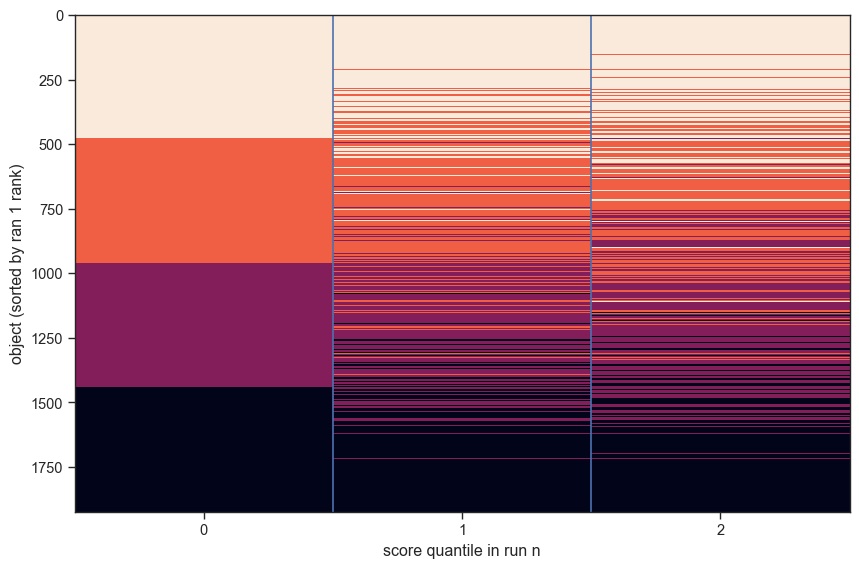

In [107]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(df.iloc[:,3:], interpolation='none')
ax.set_aspect(0.001)
ax.set_xlabel("score quantile in run n")
ax.set_xticks(range(len(df.columns)-3))
ax.set_ylabel("object (sorted by ran 1 rank)")
plt.grid(None)
ax.axvline(0.5)
ax.axvline(1.5)


In [108]:
top_quantile = df[df["quartile_if1"]==df["quartile_if1"].max()].iloc[:,3:]
print(f'fraction of run2 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if2"]).sum() / top_quantile.shape[0]}')
print(f'fraction of run3 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if3"]).sum() / top_quantile.shape[0]}')

fraction of run2 top quantile in run 1 0.8336798336798337
fraction of run3 top quantile in run 1 0.8274428274428275


In [109]:
df.index.name = "snid"

In [110]:
df["class"] = y_anom_df

In [111]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X_normal_df,y_normal_df)

DistanceMetricClassifier()

In [112]:
dist_df_dict = {}
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X_anom_df, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df['minimum_distance'] = dist_df.min(axis=1)
    dist_df['median_distance'] = dist_df.median(axis=1)

    dist_df.index.name = "sample_num"
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/32 [00:00<?, ?it/s]

In [113]:
n_metrics = len(unique_metrics)
clusters = np.unique(y_normal_df)
n_clusters =len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=1924
m: n_metrics=32
k: n_clusters=4


In [123]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i,f"{cluster}_dist"]

In [124]:
dist_df_arr.shape

(1924, 4, 32)

In [126]:
dist_aggregates = np.zeros(( len(dist_df_dict["Euclidean"]), 3, 2))
dist_aggregates.shape

(1924, 3, 2)

In [127]:
dist_df_dict[utils.get_metric_name(metric)]

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,minimum_distance,median_distance
sample_num,,,,,,
0,10.768581,15.251465,99.541223,5.247921,5.247921,10.768581
1,4.154799,30.715712,497.648475,14.299332,4.154799,14.299332
2,42.460405,22.525607,41.636940,15.247344,15.247344,22.525607
3,110.797336,123.254470,102.902851,108.238754,102.902851,108.238754
4,123.777937,19.538802,8.946582,12.702020,8.946582,12.702020
...,...,...,...,...,...,...
1919,478.177294,42.694496,12.551029,56.743045,12.551029,42.694496
1920,43.884191,31.659549,89.576117,12.643754,12.643754,31.659549
1921,72950.534332,2806.710707,117.531116,5764.293674,117.531116,2806.710707


In [128]:
dist_minK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
                           for i,metric in enumerate(unique_metrics)])
dist_medK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
                           for i,metric in enumerate(unique_metrics)])

In [148]:
dist_aggregates = pd.DataFrame(np.concatenate([np.percentile(dist_minK_by_M, [0,0.25,0.5], axis=0),
                          np.percentile(dist_medK_by_M, [0,0.25,0.5], axis=0)]).T,
                          columns=[k+m for k in ["min", "med"] for m in ["min", "25th", "med"]],
                              index=X_anom_df.index)
dist_aggregates.index.name = "snid"

dist_aggregates = dist_aggregates.merge(df.iloc[:,:3], left_index=True, right_index=True)
dist_aggregates

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
45455629,-6.436770,-5.937585,-5.438399,-2.382316,-2.195318,-2.008320,-0.040968,-0.028249,-0.023969
58717562,-8.009040,-7.385452,-6.761864,-2.621160,-2.414022,-2.206884,-0.024838,-0.032008,-0.019761
106187660,-2.243724,-2.068679,-1.893634,-1.837243,-1.693560,-1.549878,-0.016388,-0.010255,-0.008687
119867702,-1.746788,-1.609449,-1.472110,-1.354587,-1.240471,-1.126355,-0.024551,-0.002310,-0.000717
148019839,-4.813164,-4.437454,-4.061745,-2.126353,-1.952034,-1.777715,0.005072,0.003665,-0.002042
...,...,...,...,...,...,...,...,...,...
69018019,-1.204938,-1.111073,-1.017208,-0.556136,-0.510215,-0.464294,0.038510,0.046227,0.034200
97601275,-8.550280,-7.887538,-7.224795,-2.421328,-2.233011,-2.044693,0.023298,0.026593,0.048065
97897233,-2.173014,-2.000915,-1.828817,-0.575977,-0.524891,-0.473804,0.068889,0.073125,0.063602


In [149]:
dist_aggregates_ranks = dist_aggregates.iloc[:, :].rank(axis=0, ascending=False).astype(int)
dist_aggregates_ranks

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
45455629,962,957,952,1198,1198,1202,1752,1671,1687
58717562,1215,1211,1206,1461,1460,1458,1596,1703,1651
106187660,395,397,396,701,708,712,1468,1424,1522
119867702,270,271,270,364,362,362,1592,1308,1424
148019839,611,609,610,956,952,947,1144,1202,1438
...,...,...,...,...,...,...,...,...,...
69018019,60,60,59,52,52,52,553,378,769
97601275,1314,1313,1310,1239,1242,1245,823,744,512
97897233,386,386,384,56,56,56,174,100,280


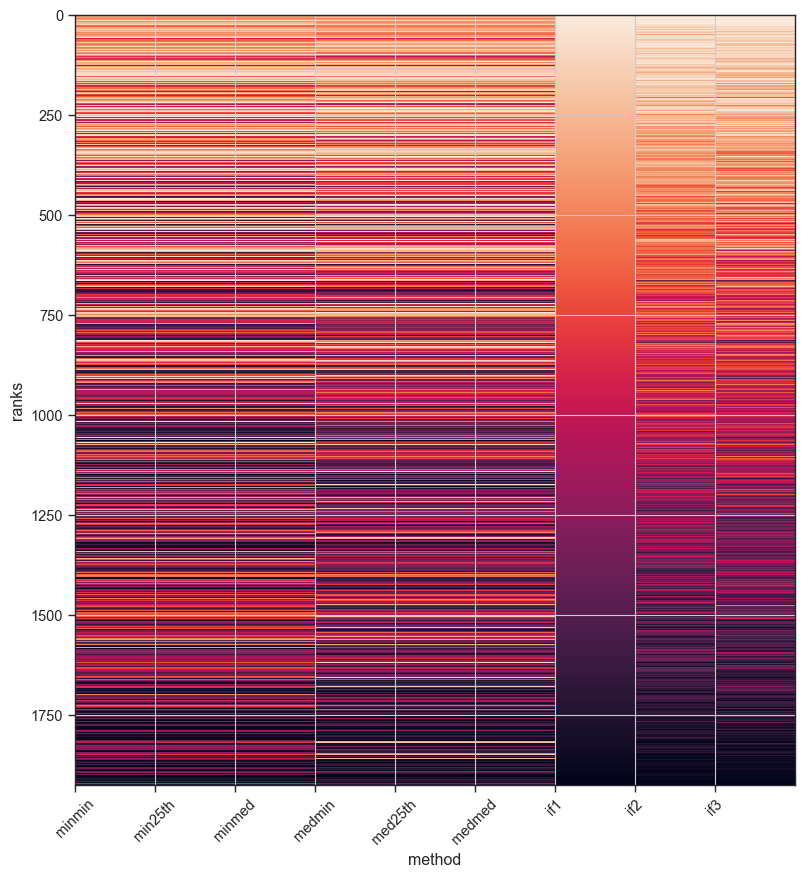

In [150]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(dist_aggregates_ranks.sort_values(by="if1", ascending=False), interpolation='none')
ax.set_aspect(0.005)
ax.set_xticks(np.arange(-0.5, 8.5), labels=dist_aggregates_ranks.columns, rotation=45)
ax.set_ylabel("ranks")
ax.set_xlabel("method")
ax.grid('off')

/Users/sidchaini/miniconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


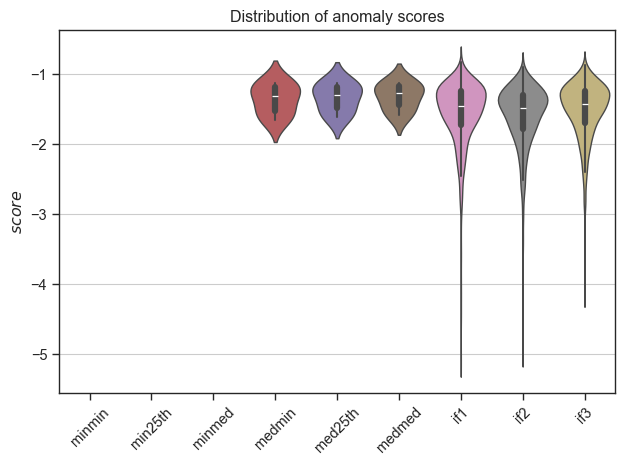

In [151]:
sns.violinplot(data=pd.DataFrame(np.log10(dist_aggregates), columns=dist_aggregates.columns))
plt.title(f'Distribution of anomaly scores')
plt.ylabel(r"$score$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [152]:
min_dists_across_clusters = []
median_dists_across_clusters = []

for metric in unique_metrics:
    metric_str = utils.get_metric_name(metric)
    dist_df = dist_df_dict[metric_str]
    min_dists_across_clusters.append(dist_df["minimum_distance"].to_numpy())
    median_dists_across_clusters.append(dist_df["median_distance"].to_numpy())


min_dists_across_clusters = np.array(min_dists_across_clusters)
median_dists_across_clusters = np.array(median_dists_across_clusters)

In [153]:
min_dists_across_clusters = []
median_dists_across_clusters = []

for metric in unique_metrics:
    metric_str = utils.get_metric_name(metric)
    dist_df = dist_df_dict[metric_str]
    min_dists_across_clusters.append(dist_df["minimum_distance"].to_numpy())
    median_dists_across_clusters.append(dist_df["median_distance"].to_numpy())

min_dists_across_clusters = np.array(min_dists_across_clusters)
median_dists_across_clusters = np.array(median_dists_across_clusters)

In [154]:
minK_pcM10_25_50 = np.percentile(min_dists_across_clusters, [0, 0.1, 0.25, 0.5], axis=0)
medianK_pcM10_25_50 = np.percentile(median_dists_across_clusters, [0, 0.1, 0.25, 0.5], axis=0)

In [155]:
min_dists_across_clusters.shape

(32, 1924)

In [156]:
df_all = pd.DataFrame(minK_pcM10_25_50.T, columns=["min_min", "min_pc10", "min_pc25", "min_pc50"])
df_all = df_all.merge(pd.DataFrame(medianK_pcM10_25_50.T,
                                   columns=["min_min", "median_pc10", "median_pc25", "median_pc50"]))
df_all

,min_min,min_pc10,min_pc25,min_pc50,median_pc10,median_pc25,median_pc50
